# Flood monitoring and Early warning system using SARIMA-LSTM: Nairobi County

## Installations

In [ ]:
!pip install jupyter pandas numpy tensorflow


In [ ]:
# install one by one if you face installation errors
!pip install matplotlib seaborn scikit-learn geopandas rasterio  

In [5]:
!pip install statsmodels



  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 479.2 kB/s eta 0:00:20
   -- ------------------------------------- 0.5/9.8 MB 479.2 kB/s eta 0:00:20
   -- ------------------------------------- 0.5/9.8 MB 479.2 kB/s eta 0:00:20
   --- ------------------------------------ 0.8/9.8 MB 447.3 kB/s eta 0:00:21
   --- ------------------------------------ 0.8/9.8 MB 447.3 kB/s eta 0:00:21
   ---- ----------------------------------- 1.0/9.8 MB 457.5 kB/s eta 0:00:20
   ---- ----------------------------------- 1.0/9.8 

In [ ]:
!pip install xarray folium earthpy statsmodels

## Import Libraries

In [1]:
# Data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras and machine learning (using standalone Keras)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Raster processing
import rasterio
from rasterio.plot import show
import geopandas as gpd

# For handling geospatial data
import folium
import earthpy as et

# Time series analysis
import statsmodels.api as sm


## Load and Visualize data

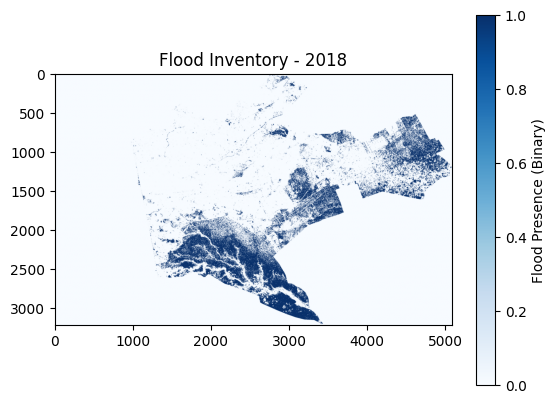

In [2]:
# Function to read raster data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)  # Read the first band
        metadata = src.meta  # Metadata for the raster
    return raster_data, metadata

# Load flood inventory rasters
flood_2018, flood_2018_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Flood_Mask2018.tif')
flood_2021, flood_2021_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Flood_Mask2021.tif')
flood_2024, flood_2024_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Flood_Mask2024.tif')

# Visualizing flood data for 2018
plt.imshow(flood_2018, cmap='Blues')
plt.colorbar(label='Flood Presence (Binary)')
plt.title('Flood Inventory - 2018')
plt.show()


## Load all conditioning factors

In [3]:
# Load conditioning factor rasters
elevation, elevation_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Elevation.tif')
slope, slope_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Slope.tif')
aspect, aspect_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Aspect.tif')
curvature, curvature_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Curvature.tif')
ls_factor, ls_factor_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/LS.tif')
twi, twi_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/TWI.tif')
rainfall_2018, rainfall_2018_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Rainfall_Nairobi-2018.tif')
rainfall_2021, rainfall_2021_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Rainfall_Nairobi-2021.tif')
rainfall_2024, rainfall_2024_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/Rainfall_Nairobi-2024.tif')
tri, tri_meta = load_raster('C:/Users/HomePC/Desktop/Work/FloodsProject/DataPrep/TRI.tif')


## Verify loaded raster

In [4]:

# Verify the loaded data (print shape and data type)
rasters = {
    "Elevation": elevation,
    "Slope": slope,
    "Aspect": aspect,
    "Curvature": curvature,
    "LS": ls_factor,
    "TWI": twi,
    "Rainfall_Nairobi-2018": rainfall_2018,
    "Rainfall_Nairobi-2021": rainfall_2021,
    "Rainfall_Nairobi-2024": rainfall_2024,
    "TRI": tri
}

# Print shape and data type of each raster
for name, data in rasters.items():
    print(f"{name} data shape: {data.shape}, Data type: {data.dtype}")

Elevation data shape: (1072, 1696), Data type: int16
Slope data shape: (1072, 1696), Data type: float32
Aspect data shape: (1072, 1696), Data type: float32
Curvature data shape: (1072, 1696), Data type: float32
LS data shape: (1072, 1696), Data type: float64
TWI data shape: (1072, 1696), Data type: float64
Rainfall_Nairobi-2018 data shape: (1073, 1695), Data type: float32
Rainfall_Nairobi-2021 data shape: (1073, 1695), Data type: float32
Rainfall_Nairobi-2024 data shape: (1073, 1695), Data type: float32
TRI data shape: (1072, 1696), Data type: float64


## Visualize one or more conditioning factors

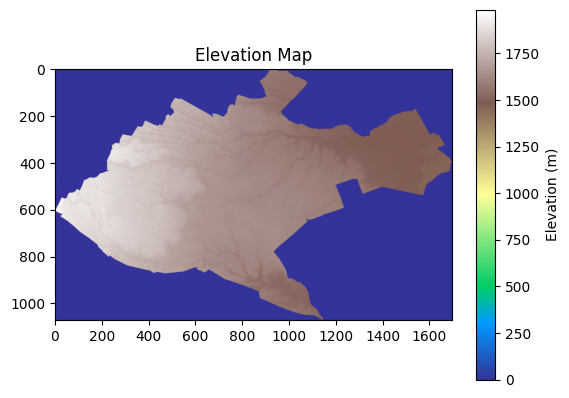

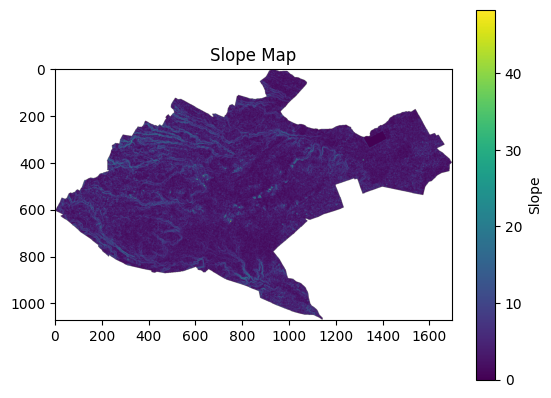

In [5]:
# Visualize Elevation
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Elevation Map')
plt.show()

# Visualize Slope
plt.imshow(slope, cmap='viridis')
plt.colorbar(label='Slope')
plt.title('Slope Map')
plt.show()


## Modeling Workflow

### Data Preprocessing

### resample, create df, split-data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Resample rasters to ensure same shape
def resample_raster(source_raster, source_meta, target_meta):
    """
    Resample a source raster to match the dimensions of a target raster.
    """
    from rasterio.warp import reproject, Resampling
    import rasterio
    import numpy as np

    # Define target shape, CRS, and transform
    target_shape = (target_meta['height'], target_meta['width'])
    target_crs = target_meta['crs']
    target_transform = target_meta['transform']

    # Create empty array to store resampled raster
    resampled_raster = np.empty(target_shape, dtype=source_raster.dtype)

    # Perform reproject operation
    reproject(
        source=source_raster,
        destination=resampled_raster,
        src_crs=source_meta['crs'],
        src_transform=source_meta['transform'],
        src_nodata=source_meta['nodata'],
        dst_crs=target_crs,
        dst_transform=target_transform,
        resampling=Resampling.bilinear
    )

    return resampled_raster

# Now ensure rasters are resampled to the correct shape, providing both source and target meta information
elevation = resample_raster(elevation, elevation_meta, elevation_meta)  # or provide a different target meta if necessary
slope = resample_raster(slope, elevation_meta, elevation_meta)
aspect = resample_raster(aspect, elevation_meta, elevation_meta)
curvature = resample_raster(curvature, elevation_meta, elevation_meta)
ls_factor = resample_raster(ls_factor, elevation_meta, elevation_meta)
twi = resample_raster(twi, elevation_meta, elevation_meta)
rainfall_2018 = resample_raster(rainfall_2018, elevation_meta, elevation_meta)
rainfall_2021 = resample_raster(rainfall_2021, elevation_meta, elevation_meta)
rainfall_2024 = resample_raster(rainfall_2024, elevation_meta, elevation_meta)
tri = resample_raster(tri, elevation_meta, elevation_meta)
flood_2024 = resample_raster(flood_2024, elevation_meta, elevation_meta)

# Flatten and create DataFrame from resampled arrays
data_dict = {
    "Elevation": elevation.ravel(),
    "Slope": slope.ravel(),
    "Aspect": aspect.ravel(),
    "Curvature": curvature.ravel(),
    "LS": ls_factor.ravel(),
    "TWI": twi.ravel(),
    "Rainfall_Nairobi-2018": rainfall_2018.ravel(),
    "Rainfall_Nairobi-2021": rainfall_2021.ravel(),
    "Rainfall_Nairobi-2024": rainfall_2024.ravel(),
    "TRI": tri.ravel(),
    "Flood_Mask": flood_2024.ravel(),  # Target variable
}

# Create DataFrame and drop rows with missing values
df = pd.DataFrame(data_dict).dropna()

# Feature-target split
X = df.drop("Flood_Mask", axis=1)
y = df["Flood_Mask"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now the data is ready for model training!


## SARIMA Model with Flood Mask as Target

In [8]:
# Section 1: SARIMA Model with Flood Mask as Target
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Limit the dataset size for SARIMA model compatibility
subset_size = min(len(y_train), 1000)  # Adjust to fit your system's capacity

# Fix index to DateTime for SARIMA compatibility
y_train_subset = y_train.iloc[:subset_size].copy()
y_train_subset.index = pd.date_range(start='2018-01-01', periods=subset_size, freq='D')

# Create and fit the SARIMA model with adjusted seasonal order
sarima_model = SARIMAX(y_train_subset, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit(disp=False)

# Generate SARIMA forecast and residuals
sarima_forecast = sarima_results.fittedvalues
residuals = y_train_subset - sarima_forecast

# Display model summary (optional)
print(sarima_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         Flood_Mask   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1632.825
Date:                            Tue, 17 Dec 2024   AIC                          -3255.649
Time:                                    09:21:07   BIC                          -3231.176
Sample:                                01-01-2018   HQIC                         -3246.342
                                     - 09-26-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0015      0.221     -0.007      0.994      -0.434       0.431
ma.L1         -0.9950      0.027   

C:\Users\HomePC\Desktop\Work\FloodsProject\Model\floods_env\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


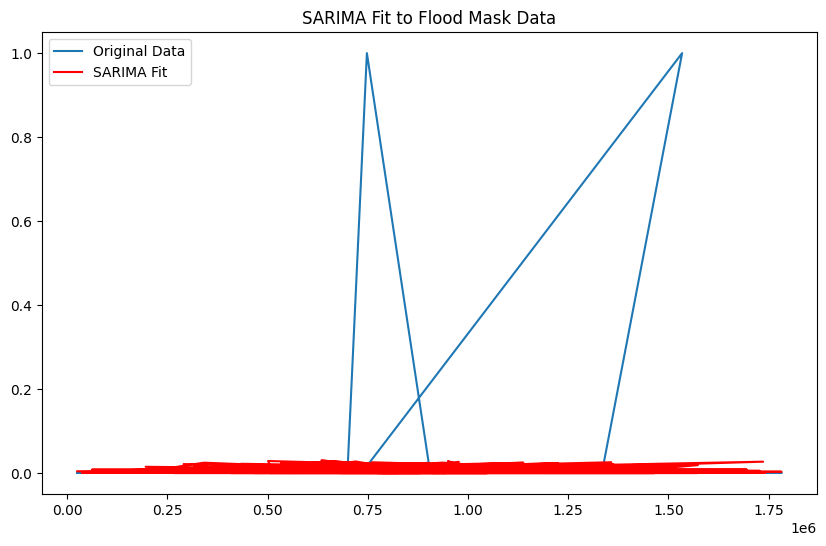

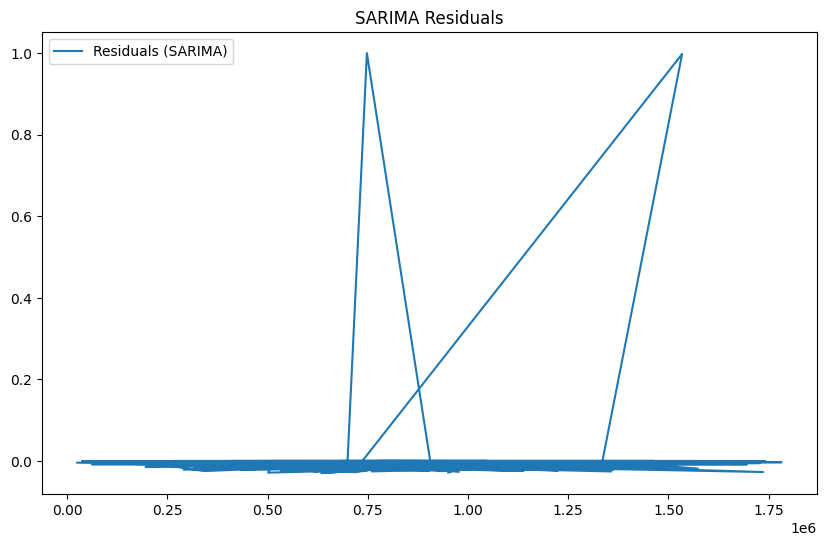

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index[:len(sarima_forecast)], y_train[:len(sarima_forecast)], label='Original Data')
plt.plot(y_train.index[:len(sarima_forecast)], sarima_forecast, label='SARIMA Fit', color='red')
plt.legend()
plt.title('SARIMA Fit to Flood Mask Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_train.index[:len(residuals)], residuals, label='Residuals (SARIMA)')
plt.legend()
plt.title('SARIMA Residuals')
plt.show()


In [11]:
# Save residuals for LSTM
residuals = residuals.values

##  Preparing Data for LSTM

In [12]:
# Section 2: Preparing Data for LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Rescale residuals for LSTM model (values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1))

# Create sequences for LSTM input (X) and output (y)
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Use the last 30 days of residuals to predict the next day

X, y = create_sequences(residuals_scaled, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# The data is now ready for LSTM model training!


## Train 

Epoch 1/20


C:\Users\HomePC\Desktop\Work\FloodsProject\Model\floods_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0032 - val_loss: 2.8335e-05
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.4955e-04 - val_loss: 4.7581e-05
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.4453e-04 - val_loss: 1.4847e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019 - val_loss: 4.7950e-05
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 8.1276e-05
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 2.4972e-05
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 2.5576e-05
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0056 - val_loss: 2.6979e-05
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039 - val_loss: 3.6153e-05
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028 - val_loss: 2.4859e-05
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 2.8169e-05
Epoch 12/20
25/25 ━━━━

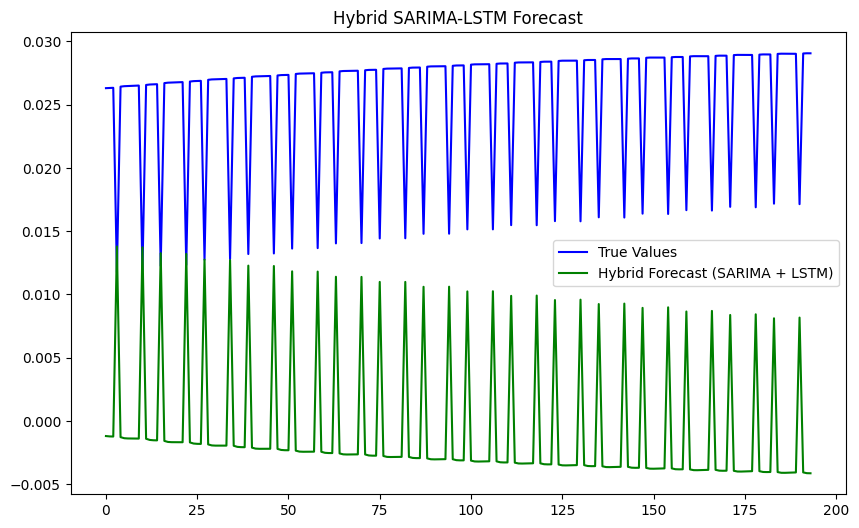

Mean Squared Error: 0.0008049678956765958


In [14]:
# Section 3: LSTM Model for Residual Forecasting
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(units=1))  # Output a single value for the residual prediction
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions with the trained LSTM model
lstm_predictions = lstm_model.predict(X_test)

# Rescale the LSTM predictions back to the original residual values
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions)

# Combine SARIMA forecast and LSTM predictions to get the final forecast
sarima_forecast_test = sarima_forecast[-len(y_test):]  # Get SARIMA forecast for the test period
hybrid_forecast = sarima_forecast_test + lstm_predictions_rescaled.flatten()

# Convert y_test back to DataFrame if needed
y_test_df = pd.DataFrame(y_test, index=range(len(y_test)), columns=['True Values'])

# Plot the results: SARIMA forecast, LSTM residual prediction, and hybrid forecast
plt.figure(figsize=(10, 6))
plt.plot(y_test_df.index, y_test_df['True Values'], label='True Values', color='blue')
plt.plot(y_test_df.index, hybrid_forecast, label='Hybrid Forecast (SARIMA + LSTM)', color='green')
plt.legend()
plt.title('Hybrid SARIMA-LSTM Forecast')
plt.show()

# Evaluate the model performance
mse = mean_squared_error(y_test, hybrid_forecast)
print(f'Mean Squared Error: {mse}')
